In [8]:
%matplotlib inline
import xarray as xr
import numpy as np
import os

import grid_tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['mathtext.default']='regular'

In [9]:
nx = 360
ny = 180
grid = grid_tools.generate_latlon_grid(nx=nx,ny=ny,lon0=-180.)
grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, nv: 4)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Dimensions without coordinates: nv
Data variables:
    xc       (lat, lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
    yc       (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    xv       (lat, lon, nv) float64 -180.0 -179.0 -179.0 -180.0 -179.0 ...
    yv       (lat, lon, nv) float64 -90.0 -90.0 -89.0 -89.0 -90.0 -90.0 ...
    area     (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 1.079e+08 ...

In [15]:
depth = xr.DataArray(np.concatenate((np.arange(0.,40.,10.),
                                     np.arange(50.,175.,25.),
                                     np.arange(200.,350.,50.),
                                     np.arange(400.,1600.,100.),
                                     np.arange(1750.,2000.,250.),
                                     np.arange(2000.,6000.,500.))),dims=('depth'))
depth

<xarray.DataArray (depth: 33)>
array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,   150.,
         200.,   250.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1750.,  2000.,  2500.,
        3000.,  3500.,  4000.,  4500.,  5000.,  5500.])
Dimensions without coordinates: depth

In [24]:
import scipy.io as sio
matdata = sio.loadmat('data/IUCN_metab_idx.mat')

dphi = xr.DataArray(matdata['dphiA'],dims=('lon','lat','depth'),coords={'lon':grid.lon,'lat':grid.lat,'depth':depth})
dphi = xr.Dataset({'dphi':dphi,'lat':grid.lat,'lon':grid.lon,'depth':depth})
dphi = dphi.transpose('depth','lat','lon')
dphi

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360)
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    dphi     (depth, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

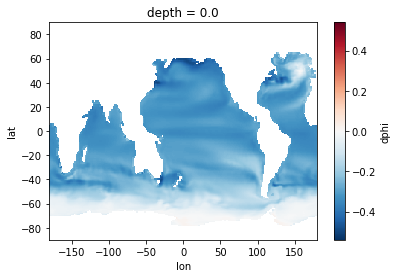

In [25]:
dphi.dphi[0,:,:].plot()

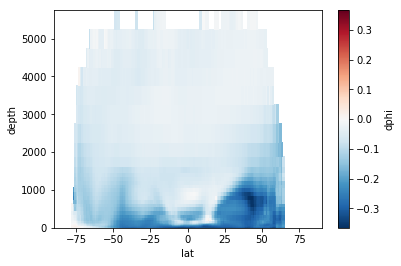

In [26]:
dphi.dphi.mean(dim='lon').plot()